<h1>Astro 283 Homework 6</h1>
Bijan Pourhamzeh


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
from scipy.optimize import fmin
from csv import reader
from astropy.io import fits

from __future__ import print_function

<h3> Problem 1 </h3>

To estimate the values of $(\alpha,\beta)$, we maximize the posterior function $p(\alpha,\beta\mid\{D\})$ with respect to $\alpha$ and $\beta$. From Baye's rule, and assuming the prior $p(\alpha,\beta)$ is uniform, this is equivalent to maximizing the likelihood function since

$$
p(\alpha,\beta\mid\{D\}) \propto p(\{D\}\mid\alpha,\beta) = \prod_i p(x_i\mid\alpha,\beta)
$$

where

$$
p(x_i\mid \alpha,\beta) = \left\{
\begin{array}{ll}
\alpha^{-1}\exp\left(-\frac{x_i+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x_i\beta}}{\alpha}\right) & \quad x_i\geq 0\\
0 & \quad\text{otherwise}
\end{array}
\right.
$$

Using <code>scipy.optimize.fmin</code>, we find that the parameters which maximize the posterior function are

\begin{eqnarray}
\alpha &\approx& 7.23\\
\beta &\approx& 7.87\times 10^{-4}
\end{eqnarray}

To compare this fit to one of a Gaussian that has a variance equal to the mean, we evaluate the ratio

\begin{eqnarray}
\frac{P(R\mid\{D\})}{P(G\mid\{D\})} &=& \frac{\int p(\alpha,\beta,R\mid\{D\}) d\alpha d\beta}{\int p(\mu,G\mid\{D\})d\mu}\\
&=& \frac{\int p(\{D\}\mid\alpha,\beta,R)p(\alpha,\beta) d\alpha d\beta}{\int p(\{D\}\mid\mu,G)p(\mu) d\mu}\\
&=& \frac{\mu^\text{max}-\mu^\text{min}}{(\alpha^\text{max}-\alpha^\text{min})(\beta^\text{max}-\beta^\text{min})}\frac{\int p(\{D\}\mid\alpha,\beta,R) d\alpha d\beta}{\int p(\{D\}\mid\mu,G) d\mu}\\
&\approx& \frac{\mu^\text{max}-\mu^\text{min}}{(\alpha^\text{max}-\alpha^\text{min})(\beta^\text{max}-\beta^\text{min})}\frac{p(\{D\}\mid\alpha_0,\beta_0,R)}{p(\{D\}\mid\mu_0,G)}\frac{\int f(\alpha,\beta,R) d\alpha d\beta}{\int g(\mu,G) d\mu}
\end{eqnarray}

where we make the approximation that the likelihoods can be approximated by the likelihoods at the best fit values times some functions $f,g$ which are functions of the parameters, best-fit values, and errors associated with the fit. We can assume that $f,g$ are approximately Gaussian, which means the integrals will be proportional to the errors, $\delta\alpha,\delta\beta,\delta\mu$. This gives us

$$
\frac{P(R\mid\{D\})}{P(G\mid\{D\})} \sim \frac{\delta\alpha\delta\beta}{(\alpha^\text{max}-\alpha^\text{min})(\beta^\text{max}-\beta^\text{min})}\frac{\mu^\text{max}-\mu^\text{min}}{\delta\mu}\frac{p(\{D\}\mid\alpha_0,\beta_0,R)}{p(\{D\}\mid\mu_0,G)}
$$

We can evaluate the last factor numerically, which comes to

$$
\frac{p(\{D\}\mid\alpha_0,\beta_0,R)}{p(\{D\}\mid\mu_0,G)} \sim 10^{51}
$$

The factors in front we assume are not close to this order of magnitude, so we can say that 

$$
\frac{P(R\mid\{D\})}{P(G\mid\{D\})} \gg 1
$$

and therefore the Rice distribution is a much better fit than the Poisson-like Gaussian.

In [2]:
#Read in student samples

samples = reader(open('rice.dat', 'rt'))
x_dat = []
for sam in samples:
    x_dat.append(float(sam[0]))
    
x_dat = np.array(x_dat)
#print(x_dat)

In [3]:
def rice_likelihood(params, x):
    '''Returns p(x|\alpha,\beta) defined above'''
    
    return 1/params[0]*np.exp(-(x+params[1])/params[0])*iv(0,2*np.sqrt(x*params[1])/params[0])

#Negative likelihood so we can use fmin
neg_RL = lambda params, x: -1*np.prod(rice_likelihood(params,x))

def gaussian_(mu, x):
    '''Returns a gaussian with variance equal to its mean'''
    
    return 1/np.sqrt(2*np.pi*mu)*np.exp(-0.5*(x-mu)**2/mu)

neg_G = lambda mu, x: -1*np.prod(gaussian_(mu,x))

In [4]:
#Optimize!

initial_r = np.array([5,0])
opt_r = fmin(neg_RL, initial_r, args=(x_dat,))

initial_g = np.array([np.mean(x_dat)])
opt_g = fmin(neg_G, initial_g, args=(x_dat,))

print(opt_r)
print(opt_g)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 17
         Function evaluations: 34
[  7.22612374e+00   7.86827536e-04]
[ 9.99631102]


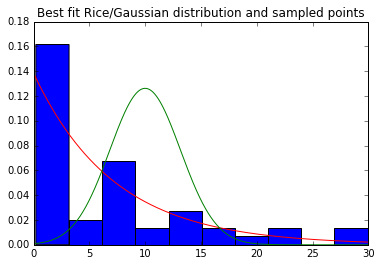

In [5]:
#Plot to see how it looks. Meh....

plt.hist(x_dat, normed=True)
x_vals = np.arange(0,30,.01)
plt.plot(x_vals, rice_likelihood(opt_r,x_vals), 'r-')
plt.plot(x_vals, gaussian_(opt_g,x_vals), 'g-')
plt.title('Best fit Rice/Gaussian distribution and sampled points')

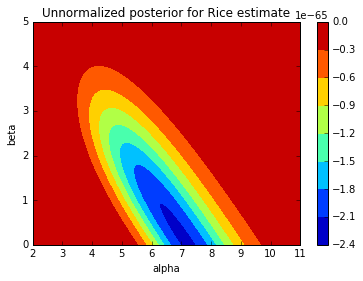

In [6]:
#Contour plot of posterior function, unnormalized

alp = np.linspace(2,11,100)
bet = np.linspace(0,5,100)
prob = np.array([[neg_RL((a,b),x_dat) for a in alp] for b in bet])
plt.contourf(alp, bet, prob)
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Unnormalized posterior for Rice estimate')

In [7]:
#Ratio of Rice likelihood at best fit parameter to Gaussian at best fit

third_factor = neg_RL(opt_r,x_dat)/neg_G(opt_g,x_dat)
print(third_factor)

1.9151801022e+51


<h3>Problem 2</h3>

Given the 3d galaxy model, we obtain an image by integrating along the first axis to obtain a perfect scene. Since the axes are pixels, integation just amounts to summing along the first index. We want to convolve the point spread function (PSF) with this image. We do this in the following steps:

1. Zero-pad the arrays by inserting them in the center of a (256, 256) array of zeros. 

2. Perform an FFT on each of the arrays.

3. Do the convolution on the fourier transformed arrays. This is jst element-wise multiplication.

4. Inverse FFT back.

5. Do an FFT shift to recenter the resulting image. Nice!

The results are shown below. The FFT method written below follows a version of the Cooley-Tukey FFT algorithm, which was described in class. I checked that it gives the same result as the numpy FFT method.

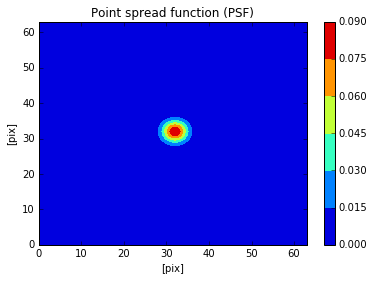

In [8]:
#Read in FITS file and plot PSF

model_file = fits.open('../../hw6prob2_model.fits')
model_data = model_file[0].data
#print(model_data.shape)

psf_file = fits.open('../../hw6prob2_psf.fits')
psf_data = psf_file[0].data
plt.contourf(psf_data)
plt.colorbar()
plt.title('Point spread function (PSF)')
plt.xlabel('[pix]')
plt.ylabel('[pix]')

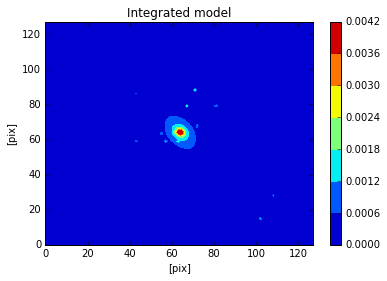

In [9]:
#Integrate model along the slow axis. 

model_int = np.sum(model_data, axis=0)
#print(model_int.shape)
plt.contourf(model_int)
plt.colorbar()
plt.title('Integrated model')
plt.xlabel('[pix]')
plt.ylabel('[pix]')

In [10]:
def zero_pad_2d(a, num):
    '''take an 2d array and pad with zeros around edges
    output is an array with size (num, num)'''
    
    a = np.asarray(a)
    size = a.shape
    
    out = np.zeros((num,num))
    
    out[int((num-size[0])/2):int((num+size[0])/2),int((num-size[1])/2):int((num+size[1])/2)] = a
    
    return out

In [11]:
#from timeit import timeit

def my_fft_1d(a, inverse=False, first_iter=True):
    '''Computes a fast fourier transform of a 1d array, a. 
    Returns a complex array of the same size. Uses the Cooley-Tukey algorithm'''
    
    n = len(a)
    out = np.zeros(n, dtype=complex)
    
    overall_factor = 1
    if inverse:
        s = -1
        if first_iter:
            overall_factor = float(1/n)
    else:
        s = 1
        
    if n == 1:
        out[0] = a[0]
    else:
        out[0:int(n/2)] = my_fft_1d(a[0::2], inverse, first_iter=False)
        out[int(n/2):] = my_fft_1d(a[1::2], inverse, first_iter=False)
        for k in range(0,int(n/2)):
            t = out[k]
            out[k] = t + np.exp(-s*2*np.pi*1j*k/n)*out[k+int(n/2)]
            out[k+int(n/2)] = t - np.exp(-s*2*np.pi*1j*k/n)*out[k+int(n/2)]
    return overall_factor*out

In [12]:
def my_fft_2d(a, inverse=False):
    '''Computes 2d FFT using my_fft_1d'''
    
    a = np.asarray(a)
    n1, n2 = a.shape
    if n1 != n2:
        print('Input must be a square array! Shape is', (n1,n2))
        return None
    N = n1
    out = np.zeros((N,N), dtype=complex)
    
    #FFT columns
    for i in range(0,N):
        out[:,i] = my_fft_1d(a[:,i], inverse, first_iter=True)
            
    #FFT rows
    for j in range(0,N):
        out[j,:] = my_fft_1d(out[j,:], inverse, first_iter=True)
        
    return out

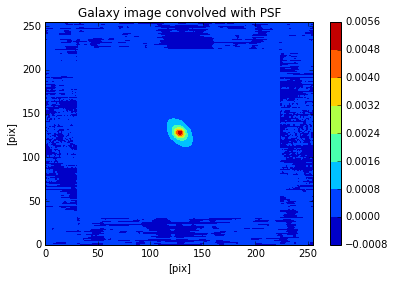

In [16]:
#Zero pad data
model_int_p = zero_pad_2d(model_int, 256)
psf_data_p = zero_pad_2d(psf_data, 256)

#FFT padded data
model_int_f = my_fft_2d(model_int_p)
psf_data_f = my_fft_2d(psf_data_p)

#Do convolution in Fourier space, i.e. element-wise multiplication
conv_f = model_int_f*psf_data_f

#Inverse FFT back
conv = my_fft_2d(conv_f, inverse=True)

#Plot result
plt.contourf(np.real(np.fft.fftshift(conv)))
plt.colorbar()
plt.title('Galaxy image convolved with PSF')
plt.xlabel('[pix]')
plt.ylabel('[pix]')